In [2]:
#Common Packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import json

### Data Cleaning _ First Stage

In [185]:
data = pd.read_csv("R_cleaned_data.csv",na_values=["nan","None","NaN"])

data.drop("Unnamed: 0", axis=1, inplace=True)

# Lets clean the price range data for Teableau. 

data["priceRange"] = data["priceRange"].astype(str).map(lambda x : x.replace("USD ", "").replace(" ",""))

priceRange = data["priceRange"].str.split("-",n=1, expand = True)

data = data[["cleanedPostalCode","categories","city","lat","long","menus","name","province","priceRange"]]

data.head(3)

,cleanedPostalCode,categories,city,lat,long,menus,name,province,priceRange
0,33759,"American, American (new), Clearwater Restauran...",Clearwater,27.971165,-82.696938,"[{""descriptions"":""A combination of diced ham a...",Village Inn Restaurant and Bakery,FL,nan
1,40202,Caf and Sandwich Place,Louisville,38.257020,-85.760013,"[{""descriptions"":""Mexican coke, ale 8, q soda,...",Atlantic No. 5,KY,25.00-40.00
2,98373,"American, Barbecue, Puyallup Restaurants, Barb...",Puyallup,47.154828,-122.303992,"[{""descriptions"":""create your own full slab. p...",Famous Dave's,WA,10.00-15.00


### Check data distribution with states

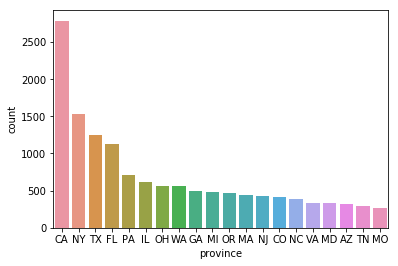

In [10]:
#data.shape # We get 18155 rows

#Now lets see data distribution by state.

state_count = data.groupby(by="province").province.count().to_frame().rename(columns = {'province':'count'}).reset_index()

state_count = state_count.sort_values(by="count",ascending=False)

sns.barplot(x="province",y="count", data=state_count[:20])

#As we can see, most data rows we get are from California, New York, Texas, Florida, and Pennsylavinia. 

All the other exploratary data analytics will be done with Tableau.
For Python purpose, we will focus on the natural language processing from below. 

In [187]:
#Export the CSV for Teableau 

data.to_csv(r'data_for_teableau.csv')

### Categorize the cuisines in the data
Since this is a super "raw" data. The classification needs to be done by ourselves. 
I created another file "Text_Classficiation_Function" to achieve this function
Inside that, since it is related with text cleaning, I also imported the file "Text_Normalization_Function"

In [15]:
data["menus"].describe() #18155 and there are only 7091 valid data

data["categories"].describe() #18155 and there are 17993 valid data

# Categorize them into American, Chinese, Mexican, Italian, 

# Thai, Indian, Japanese, Korean,Vietnamese, African, Middle Estern, Cafe, Bar(14 categories).

count          17993
unique          9950
top       Restaurant
freq            2257
Name: categories, dtype: object

In [ ]:
%run ./Text_Classification_Function.ipynb 

In [17]:
data["categories"] = data["categories"].astype(str)

new_category = []

for i in range(data.shape[0]):
    
    new_category.append(categorize_cuisine(cuisine_category,data["categories"][i]))

In [18]:
new_category = pd.Series(new_category)

sum(new_category!="NA") # Now we have 13265 rows left. 

#To get this number, I modified the category list several times in the Text_Classification_Function file. 
#You get definitly get a more accurate number by checking the "NA" value and keep modifying. 

13265

In [19]:
#This is the code for you to check the NA value. 
# for i in range(100):
#     if(new_category[i]=="NA"):
#         print(data.categories[i])

In [20]:
# Now we try to dig out the information based on state, city and categories. 

new_data = data[["city","province"]].copy()
new_data["category"] = new_category
# Now we create dummy variables for our new category

In [21]:
def create_category_dummy(category_list,new_data):
    for i in range(len(category_list)):
        new_data[category_list[i]] = new_data.category.apply(lambda x: 1 if category_list[i] in x else 0)
    return new_data
category_list = list(cuisine_category.keys())
new_data = create_category_dummy(category_list,new_data)

In [22]:
#Lets check the category distribution for the first 6 states which has most vegetarian reastaurants.
first_six_state = new_data[new_data["province"].isin(["CA","NY","TX","FL","PA","IL"])]
a = first_six_state.groupby(by="province").mean().reset_index()
a = a.transpose()
a.rename(columns=a.iloc[0]).drop(a.index[0])
a.to_csv("state_distribution_tableau.csv")

In [23]:
#Lets check the category distribution for the cites. 
#We only save cities with more than 10 data. 
b = new_data.groupby(by="city").sum().reset_index()
b["total_number_of_res"] = b.iloc[:,1:].sum(axis=1)
b = b[b["total_number_of_res"]>=10]
b.to_csv("city distribution.csv")

### Menu Text Analysis

Most of the work we can do them with Tableau since there is no sense we write 200 lines code for visualization when we have an easier way to deal with them. 

However, there is a last thing I want to do :

Do a text mining over the menu data we get. 

I thought about classify them into categories. It is not very realistic since there are too many repetitive stuff inside and the rest of the features are not enough to do that job. Mostly importantly, it is not business meaningful. 

In [111]:
#Create a string to get all the menu descriptions 
menu_description = []
for i in range(10):
    try: 
        menu_item = json.loads(data["menus"][i])
        for element in menu_item:
            for key, value in element.items():
                if(key=="descriptions"):
                    menu_description.append(value)
    except Exception as e:
        continue

In [129]:
menu_description = "".join(str(x) for x in menu_description)
from textblob import TextBlob
menu_nouns = TextBlob(menu_description).noun_phrases
menu_nouns = "".join(str(x) for x in menu_nouns)
#WordCloud originally has a stopwords option, but it does not function very well. 

#Here we will use a Textblob package to extract the nouns. (It is faster than NLTK)
#You might have to download the brown from NLTK
#You have to ajust the stopwords based on the cloud you generated.
#For sure we have to delete the meat here.... very unfortunate. Most vegetarian restaurants serve meat as well . 
STOPWORDS = ["beef","chicken","pork","sauce","link","our","two","meat","style","combo","bob","jack","ice","fire","specialty"]


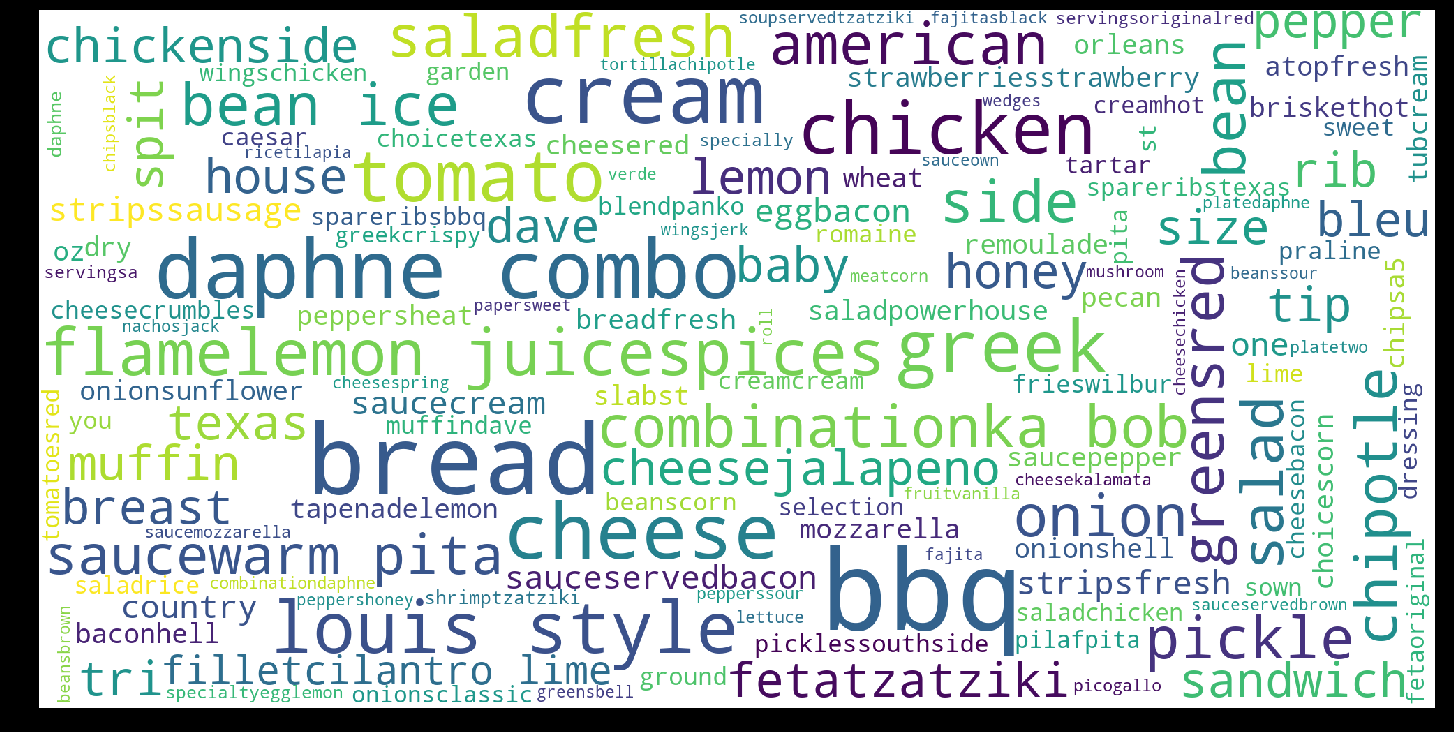

In [175]:
from wordcloud import WordCloud,ImageColorGenerator

wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white",width=2000, height=1000,max_font_size=160,\
                     min_font_size=18,contour_color="black").generate(menu_nouns)
# Open a plot of the generated image.

plt.figure(figsize=(20,15), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

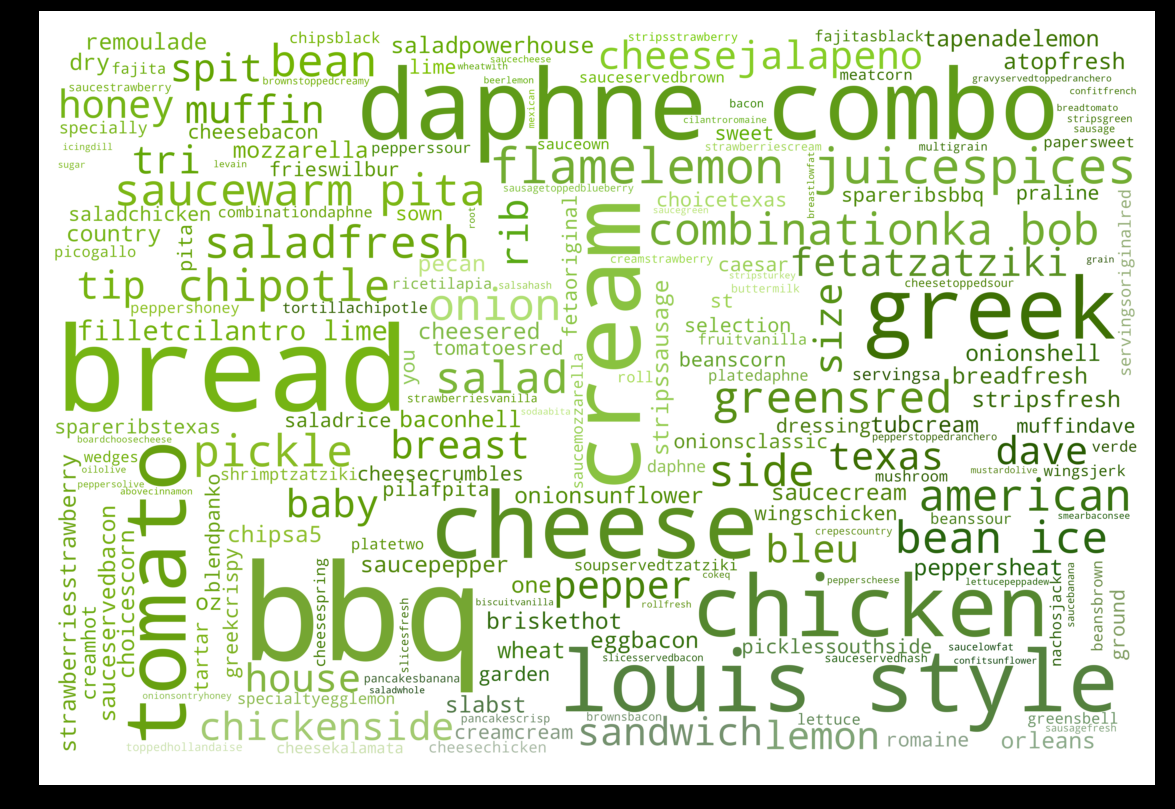

<Figure size 432x288 with 0 Axes>

In [183]:
#Below is just for fun, you can mask the word cloud you generated. 
#I have no idea why it is so small. 
#But you can definitely find some free wordcloud tools online. 

from PIL import Image
mask = np.array(Image.open("cabbage.jpg"))
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white",\
                       width=2000, height=1000, max_font_size=720,\
                      mask=mask).generate(menu_nouns)
image_colors=ImageColorGenerator(mask)
plt.figure(figsize=(20,15), facecolor='k')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig("wordcloud.jpeg", dpi=800)